# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, we consider the effect of calibration with the MLPClassifier from sklearn.

5-fold train-test splits with scaling, dimensionality reduction, and resampling have already been preprocessed on the full dataset. The results are visualized and discussed.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from os.path import exists
from tqdm.notebook import tqdm

# typing
from typing import Dict, List, Union

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

# classifiers
from sklearn.neural_network import MLPClassifier

# calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 5.43 s


In [4]:
# Location of cross validation .feather files
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 122 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [5]:
METRICS = (
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 142 ms


In [6]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 116 ms


# Models

We consider MLPClassifier alone in this notebook.

In [7]:
MODELS = {
    "MLP": lambda: MLPClassifier(random_state=SEED),
}

_ = gc_collect()

time: 121 ms


# Test harness

This section defines functions for evaluating models.

In [8]:
def prep_y_pred(label: Union[int, bool], case: str) -> List:
    """Prepares labels for AUROC scoring"""
    if "ternary" in case:
        _ = [0, 0, 0]
        _[int(label)] = 1
        return np.asarray(_, dtype=np.int8)
    else:
        return label


def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = True
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean, roc_auc = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        # helper function
        read_feather_cv = lambda _set: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{_set}{'' if _set == 'X_test' else f'_{case[:3]}'}.feather"
        )

        # load training data
        try:
            X_train, y_train = read_feather_cv("X_train"), np.squeeze(
                read_feather_cv("y_train").values
            )
        except FileNotFoundError:
            break

        # initialize model
        model = CalibratedClassifierCV(
            base_estimator=MODELS[model_base](),
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
            n_jobs=-1,
        )

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": np.squeeze(read_feather_cv("y_test").values),
            "y_pred": predicted,
        }
        balanced_accuracy.append(balanced_accuracy_score(**score_params, adjusted=True))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))
        roc_auc.append(
            roc_auc_score(
                y_true=score_params["y_true"].astype(np.int8),
                y_score=np.stack(
                    pd.Series(score_params["y_pred"]).swifter.apply(
                        prep_y_pred, case=case
                    )
                ),
                average="weighted",
                multi_class="ovo",
            )
        )
        del score_params
        del predicted
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


_ = gc_collect()

time: 126 ms


The next cell evaluates models.

In [9]:
case = "ternary"
for model in MODELS:
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

evaluating MLP...
fitted in 901.74 s
predicted in 0.74 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 184466.26it/s]


MLP fold 1 completed in 905.65 s
fitted in 914.44 s
predicted in 0.29 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 221059.76it/s]


MLP fold 2 completed in 919.26 s
fitted in 886.84 s
predicted in 0.41 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 172613.08it/s]


MLP fold 3 completed in 891.47 s
fitted in 753.32 s
predicted in 0.53 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 151301.81it/s]


MLP fold 4 completed in 757.55 s
fitted in 948.35 s
predicted in 0.40 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 155159.67it/s]


MLP fold 5 completed in 953.22 s
stored MLP for ternary classification in 4427.79 s
time: 1h 13min 47s


In [10]:
# save predictions
predictions_df = pd.DataFrame(predictions_)[["model", "case", "fold", "y_pred"]]
predictions_df.case = predictions_df.case.astype("category")
predictions_df.fold = predictions_df.fold.astype(np.uint8)
predictions_df.y_pred = predictions_df.y_pred.swifter.apply(np.int8)
predictions_df.to_feather(
    f"{DATA_OUT_FOLDER}/calibrated_untuned_MLP_predictions_CV5.feather"
)
del predictions_df
_ = gc_collect()

Pandas Apply: 100%|██████████| 5/5 [00:00<00:00, 2501.67it/s]

time: 203 ms


Let's peek at the results.

In [11]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["model_name"], ascending=True)
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(
        by=["balanced_accuracy", "geometric_mean", "f1", "roc_auc"], ascending=False
    )
    .sort_values(by=["case"], ascending=True)
    .reset_index(drop=True)
)[
    [  # selection order
        "model_name",
        "case",
        "geometric_mean",
        "f1",
        "roc_auc",
        "balanced_accuracy",
        "fit_time",
        "predict_time",
    ]
]
results_df.loc[:, "case"] = results_df.loc[:, "case"].astype("category")
results_df

,model_name,case,geometric_mean,f1,roc_auc,balanced_accuracy,fit_time,predict_time
0,MLP,ternary,0.522442,0.598856,0.657418,0.318457,880.937812,0.4766


time: 51 ms


# Results

In this section, we visualize results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [12]:
METRIC_NAMES = {
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "fit_time": "Fit Time",
    "roc_auc": "Area Under ROC Curve",
    "geometric_mean": "Geometric Mean",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 134 ms


In [13]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(8)
    g.fig.set_figheight(4)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 131 ms


  0%|          | 0/6 [00:00<?, ?it/s]

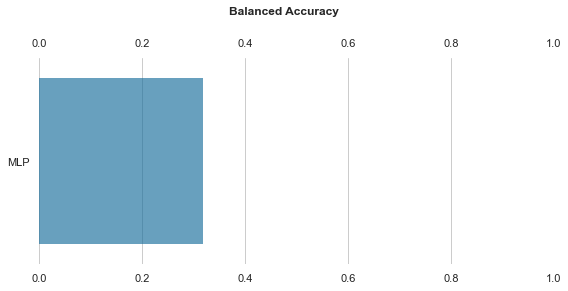

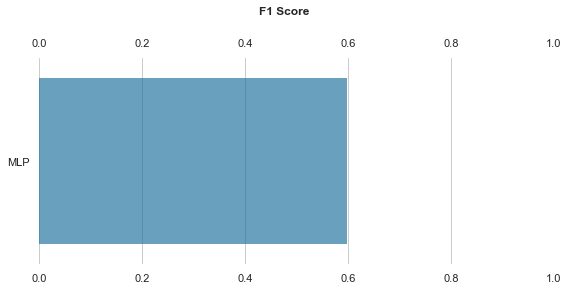

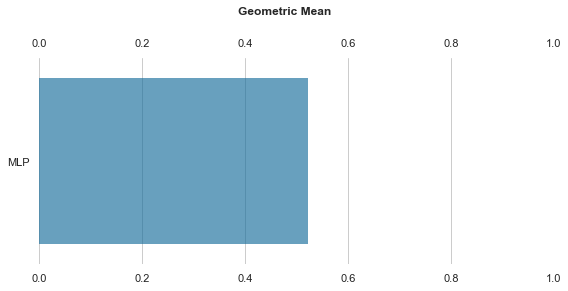

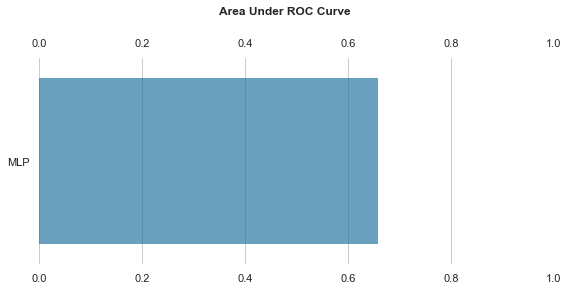

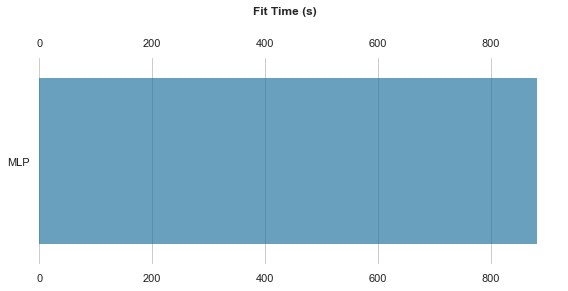

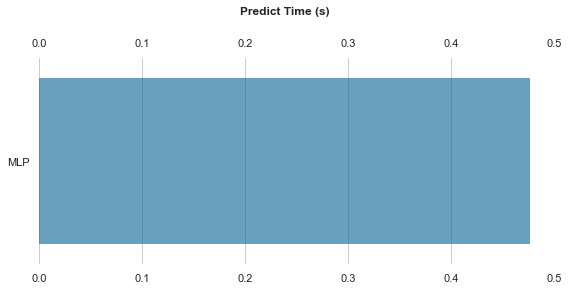

time: 2.35 s


In [14]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [15]:
# save table of results
results_df.to_csv(
    f"{DATA_OUT_FOLDER}/calibrated_untuned_full_MLP_ternary_results_CV5.csv"
)

time: 12 ms


# Discussion

It may be conceptually cleaner to apply calibration based on the class distributions before resampling. It should be fine nonetheless since false positive are about as costly as false negatives.

The plots are uninformative since MLP is the only model, but compared to other classifiers evaluated previously, the calibrated MLP performed noticeably worse in all measures except F1, where it outperformed the others. The calibrated MLP outperformed the uncalibrated equivalent.

The scaling, resampling, and dimensionality reduction transformations may not have been beneficial for deep learning.

It may be faster to calibrate an MLP than to calibrate a SVC model.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 4444.8195831775665 s
time: 122 ms


[^top](#Contents)